# Imports

In [2]:
import pandas as pd

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import graphviz

ModuleNotFoundError: No module named 'graphviz'

# Read data

In [3]:
df = pd.read_csv("../data/toy_data.csv", index_col=0)

In [4]:
df.head()

,pressure (psi),temperature (deg F),failure
0,15.02,192.80,no
1,15.34,199.77,no
2,15.09,197.31,no
3,14.22,199.04,no
4,14.24,205.32,no


# Generate Training and Testing Data

In [6]:
feat_names = df.columns[:-1]
class_names = df['failure'].unique()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[feat_names],
                                                    df['failure'],
                                                    test_size=0.25,
                                                    random_state=42)

# Training and Fitting the Model

In [9]:
decision_tree_classifier = tree.DecisionTreeClassifier(max_depth=2, random_state=0)
decision_tree_classifier = decision_tree_classifier.fit(X_train, y_train)

# Visualizing the Decision Tree

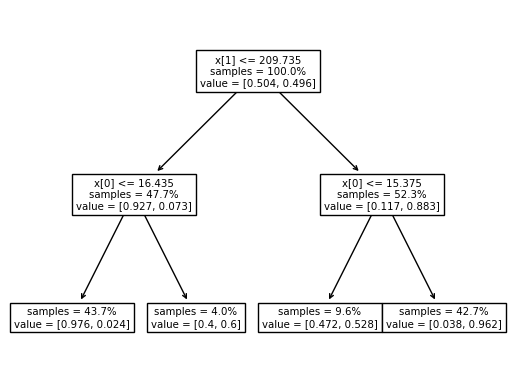

In [10]:
fig, ax = plt.subplots(1,1)
tree.plot_tree(decision_tree_classifier, ax=ax, impurity=False, proportion=True);

# Visualizing Decision Tree using Graphviz

In [ ]:
dot_data = tree.export_graphviz(decision_tree_classifier, out_file=None,
                                feature_names=feat_names,
                                class_names=class_names,
                                filled=True, rounded=True,
                                impurity=False, proportion=True)
graph = graphviz.Source(dot_data)
graph.render("../images/test")

graph

# Making predictions

In [11]:
predictions = decision_tree_classifier.predict(X_test)
probabilities = decision_tree_classifier.predict_proba(X_test)
results_df = pd.DataFrame({'prob of no':probabilities[:,0],
                         'prob of yes':probabilities[:,1],
                         'predicted class':predictions,
                         'actual class': y_test})
results_df.head()

,prob of no,prob of yes,predicted class,actual class
361,0.037500,0.962500,yes,yes
73,0.975610,0.024390,no,no
374,0.037500,0.962500,yes,yes
155,0.975610,0.024390,no,no
104,0.472222,0.527778,yes,no


# Checking Accuracy

In [12]:
accuracy = decision_tree_classifier.score(X_test, y_test)
accuracy

0.92

# Visualizing Decision Boundaries

In [13]:
colors = []
for y in y_test:
    if y == 'yes':
        colors.append('green')
    else:
        colors.append('red')
for_scatter = X_test.copy(deep=True)
        
for_scatter['failure'] = y_test
for_scatter['color'] = colors

yesses = for_scatter[for_scatter['failure']=='yes']
nos = for_scatter[for_scatter['failure']=='no']

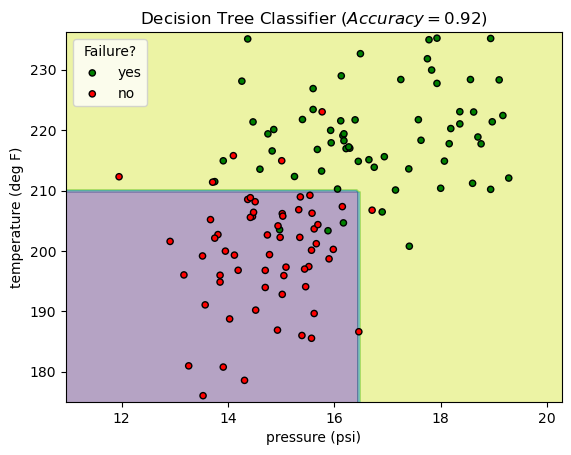

In [16]:
fig, ax = plt.subplots(1,1)
DecisionBoundaryDisplay.from_estimator(decision_tree_classifier, X_test, alpha=0.4, response_method="predict", ax=ax)
ax.scatter(yesses['pressure (psi)'], yesses['temperature (deg F)'], c=yesses['color'], s=20, edgecolor="k", label='yes')
ax.scatter(nos['pressure (psi)'], nos['temperature (deg F)'], c=nos['color'], s=20, edgecolor="k", label='no')
ax.legend(title='Failure?')
ax.set_title(f'Decision Tree Classifier $(Accuracy = {accuracy:.2f})$')
plt.show()

# Confusion Matrix

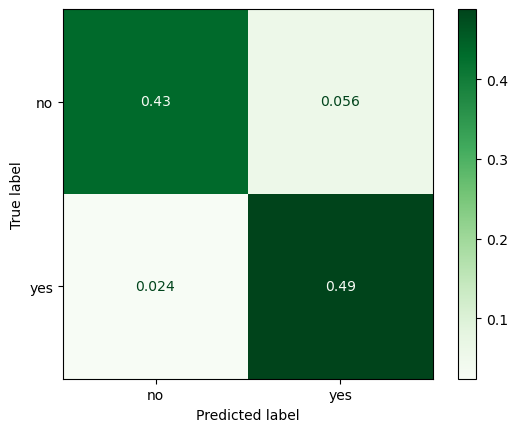

In [17]:
cm = confusion_matrix(y_test, predictions,
                      labels=class_names,
                      normalize='all')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_display.plot(cmap='Greens')
plt.show()